In [2]:
import os
import numpy as np
import matplotlib
import cv2 as cv
from matplotlib import pyplot as plt
from xml.dom import minidom
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from numpy import savez_compressed
from sklearn.model_selection import train_test_split


# Data Acquisition

# Data Exploration

## How does the dataset look like?

In [ ]:
#Downloade den datensatz in subFolder 'Images'

In [2]:
img_dir = 'Images'
raw_dir = 'raw'

In [3]:
breeds_dir = os.listdir(img_dir + '/' + raw_dir)
if '.DS_Store' in breeds_dir:
    breeds_dir.remove('.DS_Store')

print('There are ' + str(len(breeds_dir)) + ' different dog breeds in this dataset.')

There are 120 different dog breeds in this dataset.


In [4]:
img_fdir = []

for b in breeds_dir:
    dog_dir = os.listdir(img_dir + '/' + raw_dir + '/' + b)
    new_dog_dir = [img_dir + '/' + raw_dir + '/' + b + '/' + d for d in dog_dir]
    
    img_fdir.append(new_dog_dir) #Output is a 2 dimensional np array (breed, individual dog) which contains all relative paths.


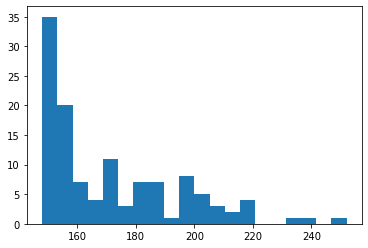

Minimum images per breed: 148
Maximum images per breed: 252


In [5]:
img_per_breed = []

for b in range(len(breeds_dir)):
    img_per_breed.append(len(img_fdir[b]))

plt.hist(img_per_breed, bins = 20)
plt.show()

print('Minimum images per breed: ' + str(min(img_per_breed)))
print('Maximum images per breed: ' + str(max(img_per_breed)))

Lets take a look into some images (one per breed):

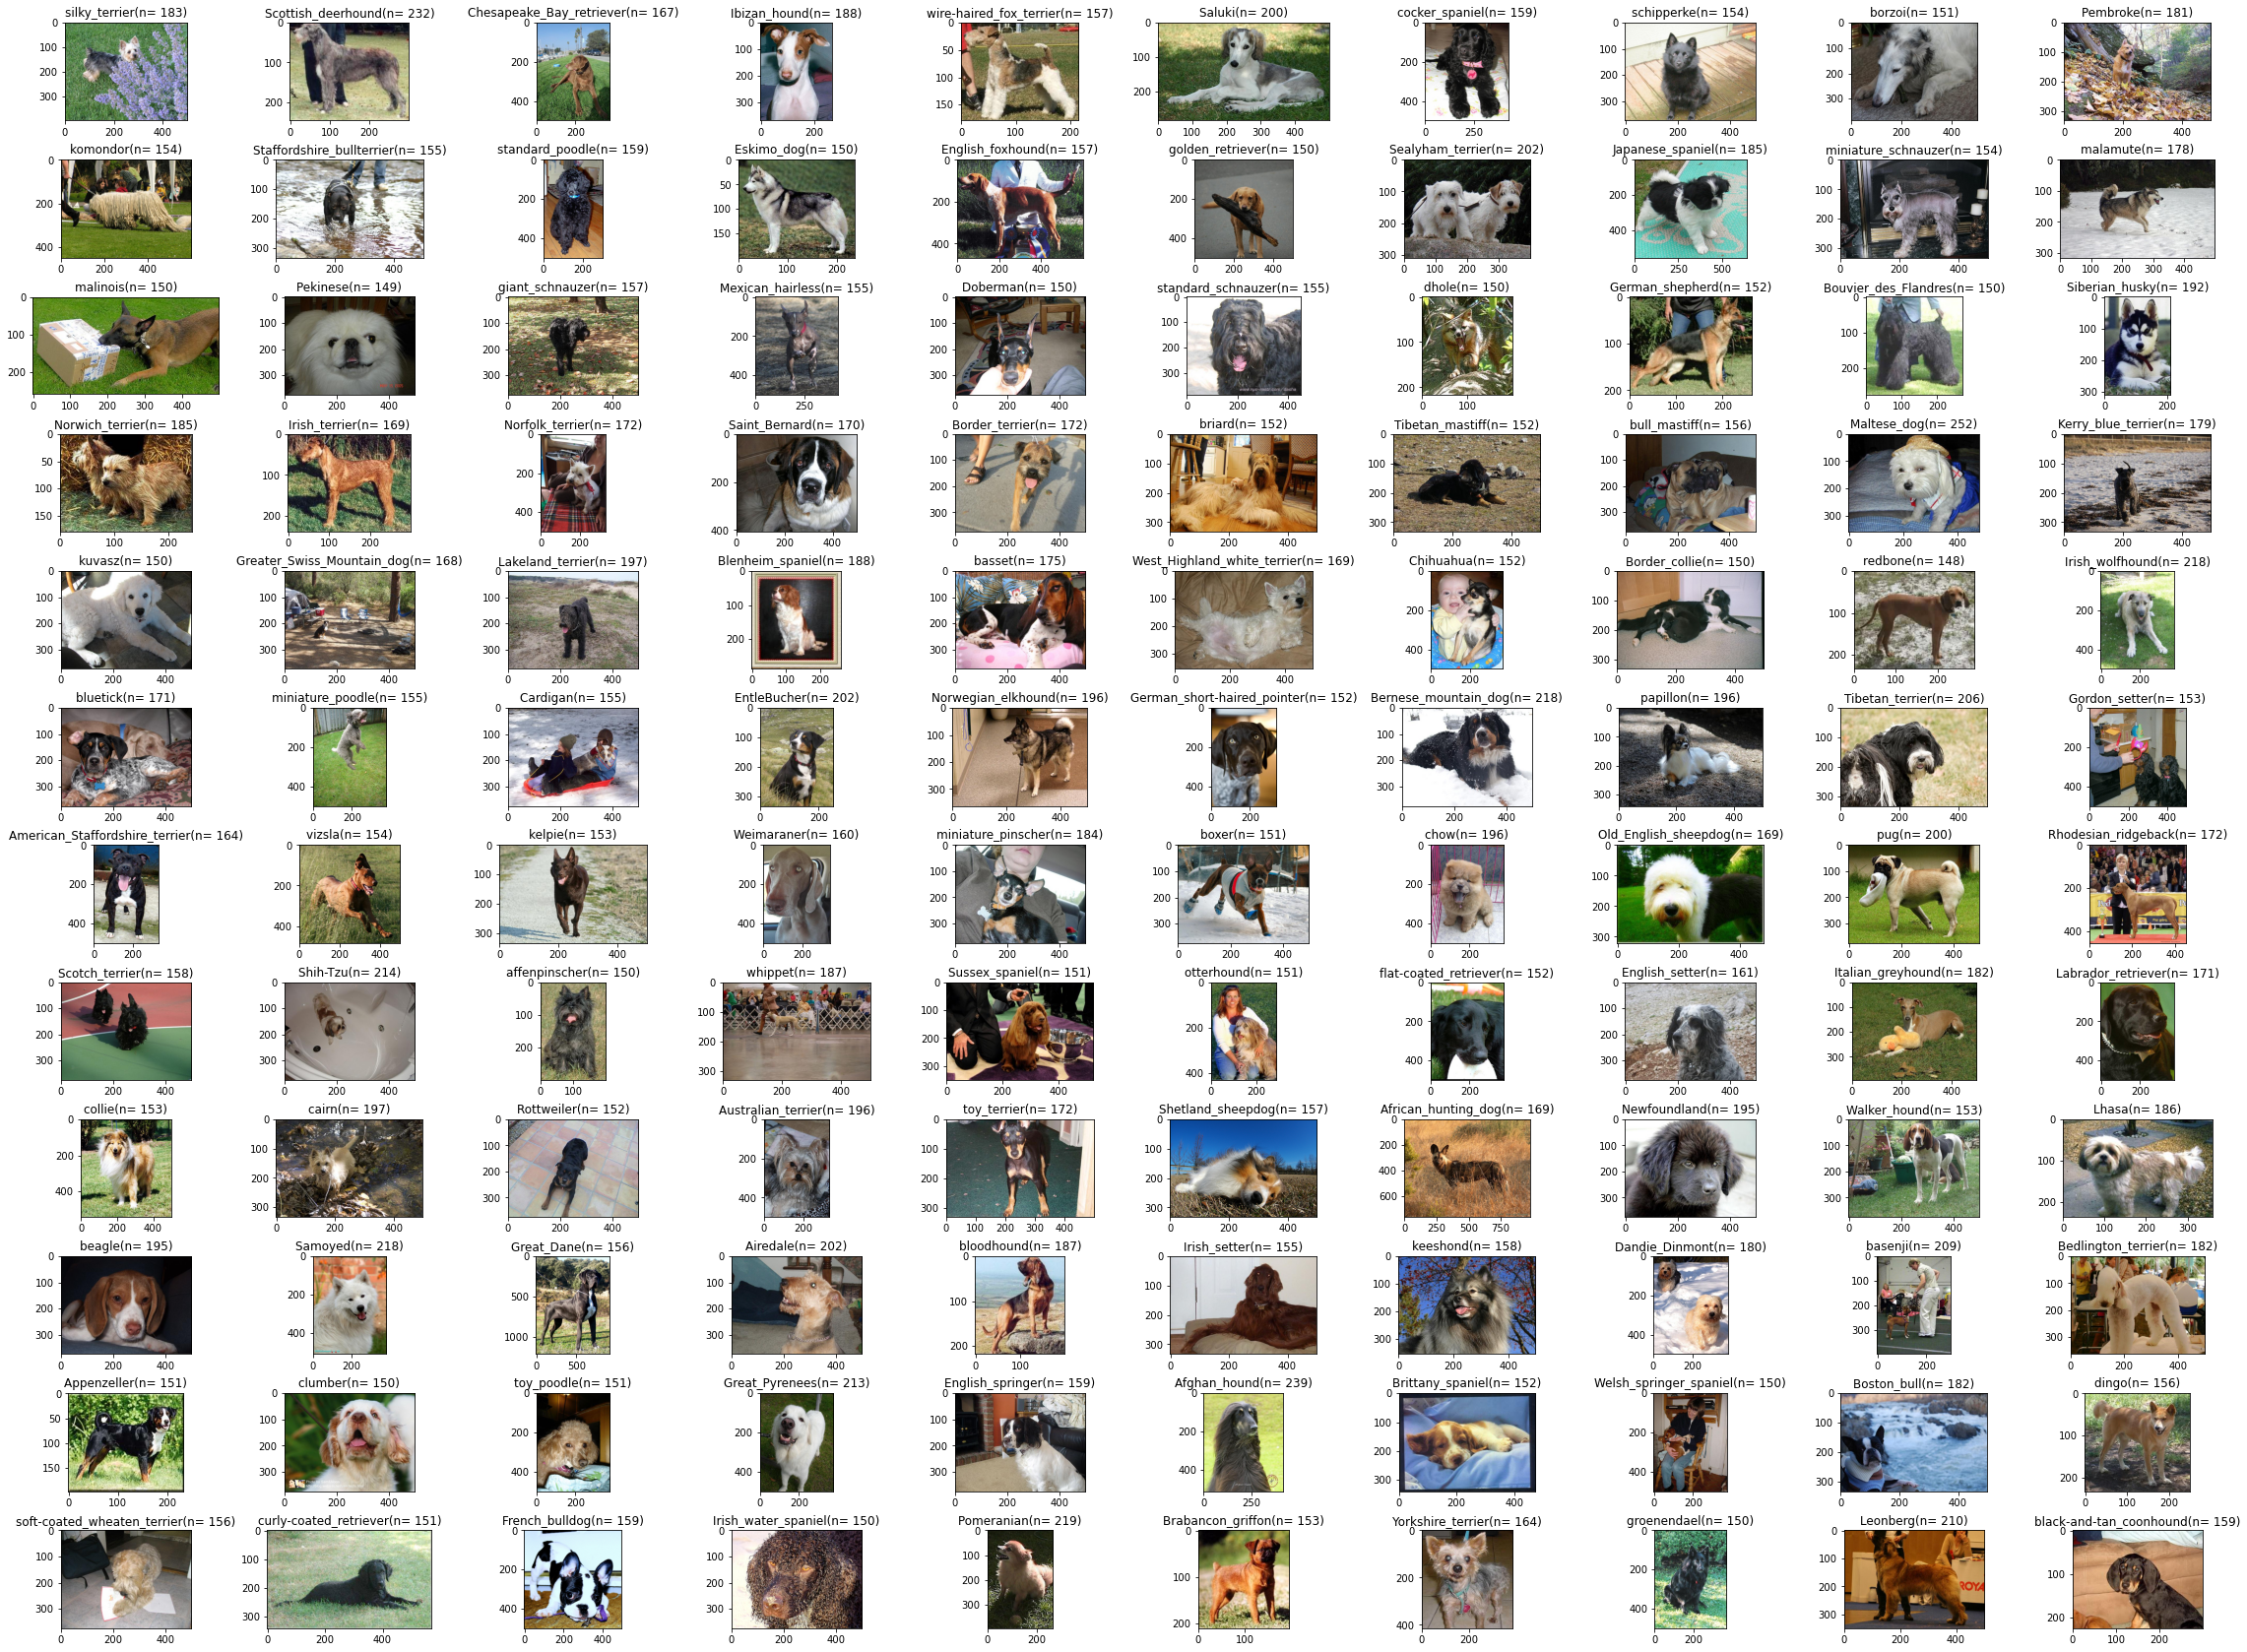

In [6]:
plt.figure(figsize=(40,30))

for b in range(len(img_fdir)):
    d = np.random.randint(0, len(img_fdir[b]))
    
    plt.subplot(12,10,b+1)

    dog = cv.imread(img_fdir[b][d])
    dog = cv.cvtColor(dog, cv.COLOR_BGR2RGB)

    plt.imshow(dog)
    plt.subplots_adjust(hspace = .4)
    
    i1 = img_fdir[b][d].index('-')
    i2 = img_fdir[b][d].find('/',img_fdir[b][d].index('-'))
    breed_name = img_fdir[b][d][i1+1:i2]
    plt.title(breed_name + '(n= ' + str(len(img_fdir[b])) + ')')


**Result:**

* Images are overall pretty diverse.
* Some dogs look straight into the camera, others look sideways or away from the camera.
* On some images, there are multiple dogs of the same breed.
* The Dogs are not always centred, some take only a quarter of the image.
* Besides the dogs, there are other elements (mostly humans) on the pictures aswell.
* Some dogs wear coats, funny little hats or have toys in their mouths.
* Pixelsize and -ratio seems to be very diverse across the dataset.
* None of the breeds is underrepresented or overrepresented. The dataset is pretty balanced overall.

## How is the images width's and height's?

In [8]:
img_sizes = []

for breed in img_fdir:
    for i in breed:
        image = Image.open(i)
        w, h = image.size
        img_sizes.append([w,h])

'''
    xmldoc = minidom.parse('Annotation/'+ f + '/' + a)
    w = int(xmldoc.getElementsByTagName('width')[0].firstChild.nodeValue)
    h = int(xmldoc.getElementsByTagName('height')[0].firstChild.nodeValue)
    size.append([w,h])

'''

img_sizes = np.array(img_sizes)

In [9]:
print('Minimum width pixels: ' + str(min(img_sizes[:,0])))
print('Minimum height pixels: ' + str(min(img_sizes[:,1])))
print('Maximum width pixels: ' + str(max(img_sizes[:,0])))
print('Maximum height pixels: ' + str(max(img_sizes[:,1])))

Minimum width pixels: 97
Minimum height pixels: 100
Maximum width pixels: 3264
Maximum height pixels: 2562


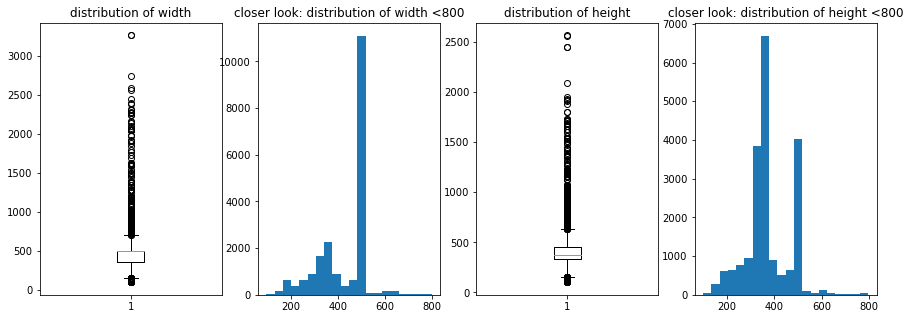

In [10]:
plt.figure(figsize=(15,5)) 

plt.subplot(1, 4, 1)
plt.boxplot(img_sizes[:,0])
plt.title('distribution of width')

plt.subplot(1, 4, 2)
plt.hist(img_sizes[img_sizes[:,0]<800][:,0], bins = 20)
plt.title('closer look: distribution of width <800')

plt.subplot(1, 4, 3)
plt.boxplot(img_sizes[:,1])
plt.title('distribution of height')

plt.subplot(1, 4, 4)
plt.hist(img_sizes[img_sizes[:,1]<800][:,1], bins = 20)
#plt.xlim(0,1500)
plt.title('closer look: distribution of height <800')


plt.show()

**Result:**

Most of the images are within a range of 200 to 500 pixels. Overall, images in the dataset are wider than taller. We should take a look into the ratio.

Before that, lets check the tiny images, since the README of Dataset says every image is atleast 200x200 pixels big. However, the minimum we found out is ~100 pixels. 
### How many are below the promised 200pixels?

In [11]:
small = len(img_sizes[np.logical_or (img_sizes[:,0] < 200, img_sizes[:,1] < 200)])
length = len(img_sizes)
share = small / len(img_sizes) * 100
txt = '{0} out of {1} ({2:.2f} %) images are smaller than the expected 200x200 pixels.'
print(txt.format(small, length, share))

973 out of 20580 (4.73 %) images are smaller than the expected 200x200 pixels.


**Result:**

These images will probably need to be upscaled.

## How is the images ratio?

In [12]:
img_ratio = img_sizes[:,0] / img_sizes[:,1] 

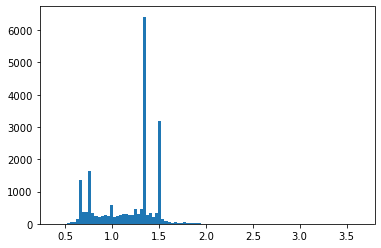

In [13]:
plt.hist(img_ratio, bins = 100)
plt.show()

In [14]:
unique, counts = np.unique(img_ratio, return_counts=True)
img_ratio_count = dict(zip(unique, counts))

In [15]:
dict(sorted(img_ratio_count.items(), key=lambda item: item[1], reverse = True)[:11])

{1.3333333333333333: 5966,
 1.5015015015015014: 2098,
 0.75: 1336,
 0.666: 706,
 1.0: 360,
 1.4970059880239521: 358,
 1.5060240963855422: 300,
 1.25: 183,
 0.668: 139,
 1.4005602240896358: 117,
 1.3368983957219251: 112}

**Result:**
There is alot of variety in the amount of pixels and the ratio. **Problem:** we need a fixed size for every image as model input.

Therefore, we need to resize most of the images to a fixed size. This leads to the question: **Which size is the best?**

Long story short: There is no clear answer to that. Lower resolution -> less information which may cause loss in accuracy, Higher resolution -> More computation power neeeded.
Most of the pretrained Models (e.g. ResNet, VGG16, Inceptionv3) use a 1:1 ratio with a pixel size higher than 200x200 (e.g. VGG16 and ResNet expect 224x224). 

So for the start: We will stick to their choice and go with 224x224. 


# Data Preparation

In [89]:
# basierend auf den Ergebnissen -> Bilder sind schon ziemlich divers, eventuell ein bisschen augmentation zur regularisierung, aber vor allem muss Bilder resizing betrieben werden.
# + Matrix mit Y Labels 
# + Train, Test, Vali Split - fertig.

## Picture Augmentation & Resizing

In [2]:
gen = ImageDataGenerator(
    rescale=1./255
    #featurewise_center=False, 
    #samplewise_center=False,
    #featurewise_std_normalization=False, 
    #samplewise_std_normalization=False,
    #zca_whitening=False, 
    #zca_epsilon=1e-06, 
    #rotation_range=0, 
    #width_shift_range=0.0,
    #height_shift_range=0.0, 
    #brightness_range=None, 
    #shear_range=0.0, 
    #zoom_range=0.0,
    #channel_shift_range=0.0, 
    #fill_mode='nearest', 
    #cval=0.0,
    #horizontal_flip=False, 
    #vertical_flip=False, 
    #preprocessing_function=None, 
    #data_format=None, 
    #validation_split=0.0, 
    #dtype=None,
)

In [3]:
aug = gen.flow_from_directory(
    directory = 'Images/raw/', 
    target_size=(224, 224), 
    color_mode='rgb', 
    #class_mode='categorical', 
    batch_size=1, 
    shuffle=False, 
    seed=1,
    #save_to_dir='Images/processed/', 
    #save_prefix=, 
    #save_format='jpg',
    #follow_links=False, 
    #subset=None,
    interpolation='nearest'
)

Found 20580 images belonging to 120 classes.


In [5]:
X=[]
y=[]
aug.reset()
for i in range(aug.__len__()):
   single_x, single_y = aug.next()
   X.append(single_x)
   y.append(single_y)

X=np.array(X)
y=np.array(y)

X = X.reshape(aug.__len__(), 224, 224, 3)

In [ ]:
y=np.concatenate([aug.next()[1] for i in range(aug.__len__())])

In [11]:
print(X.shape)
print(y.shape)

NameError: name 'X' is not defined

In [ ]:
savez_compressed('Images/processed/X.npz', X)
np.save(file='Images/processed/y', arr = y)

In [ ]:
dict_data = load('Images/processed/X.npz')
X = dict_data['arr_0']
y = np.load('Images/processed/y.npy')

In [ ]:
print(X.shape)
print(y.shape)

In [ ]:
train_ratio = 0.6
validation_ratio = 0.2
test_ratio = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 1 - train_ratio)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size= test_ratio/(test_ratio + validation_ratio)) 

In [ ]:
print('Size of X_train: ' + str(len(X_train)) + '; Size of X_val: ' + str(len(X_val)) + '; Size of X_test: ' + str(len(X_test)))

Error: Session cannot generate requests